In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import plot_utils

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])
print(img1.shape)

(96, 96)


### PSF

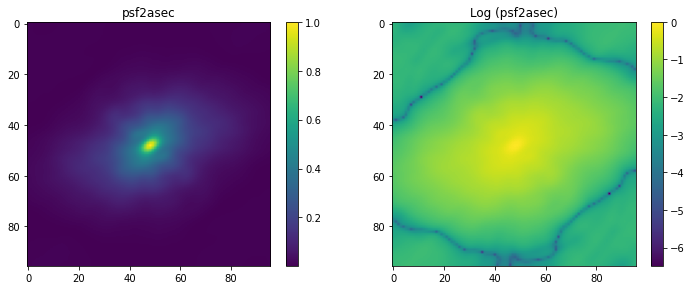

In [3]:
fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(img1)
plt.colorbar(shrink=0.375)
plt.title('psf2asec')

plt.subplot(122)
plt.imshow(np.log10(img1))
plt.colorbar(shrink=0.375)
plt.title('Log (psf2asec)')

plt.show()

# Convolution of a Gaussian Galaxy & PSF using Galsim functions

In [4]:
gal_flux = 1.e5    # total counts on the image
gal_sigma = 2.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30.        # standard deviation of the counts in each pixel

In [5]:
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
psf = galsim.Gaussian(flux=1., sigma=2.)

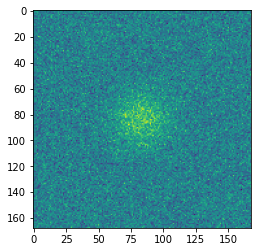

In [6]:
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

plt.imshow(image.array)
plt.show()

# Convolution of the given PSF with a Gaussian Galsim Object

In [7]:
gal_1 = np.abs(galsim.Gaussian(flux=gal_flux, sigma=gal_sigma).drawImage(nx=96, ny=96).array)
psf_img1 = galsim.Image(img1, copy=True).array

psf_img1 /= np.sum(psf_img1)

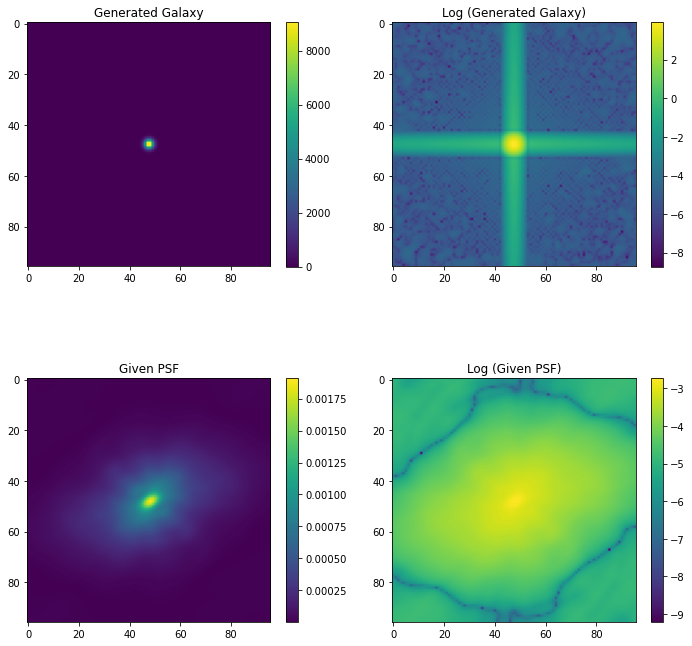

In [8]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(gal_1)
plt.colorbar(shrink=0.825)
plt.title('Generated Galaxy')

plt.subplot(222)
plt.imshow(np.log10(gal_1))
plt.colorbar(shrink=0.825)
plt.title('Log (Generated Galaxy)')

plt.subplot(223)
plt.imshow(psf_img1)
plt.colorbar(shrink=0.825)
plt.title('Given PSF')

plt.subplot(224)
plt.imshow(np.log10(psf_img1))
plt.colorbar(shrink=0.825)
plt.title('Log (Given PSF)')

m = gal_1.shape
n = psf_img1.shape

### FFT + Gaussian Noise

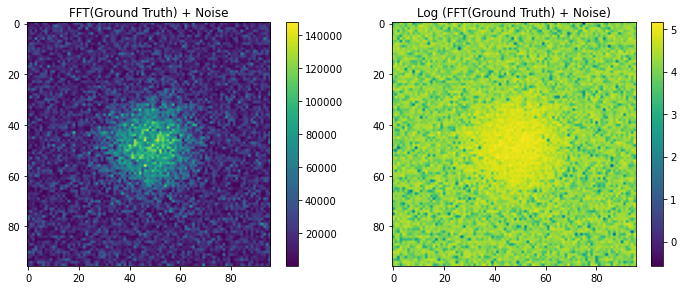

In [9]:
gal_1_fft = np.pad(np.abs(np.fft.fftshift(np.fft.fft2(gal_1))), (abs(m[0]-n[0])//2, abs(m[1]-n[1])//2 ), 'constant')     
psf_img1_fft = np.abs(np.fft.fftshift(np.fft.fft2(psf_img1)))     

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                            # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_1_fft)/SNR            # Standard deviation of noise

gal_1_fft_GSO = galsim.Image(gal_1_fft, copy=True)       # Stored as GSO
gal_1_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(np.abs(gal_1_fft_GSO.array))
plt.colorbar(shrink=0.375)
plt.title('FFT(Ground Truth) + Noise')

plt.subplot(122)
plt.imshow(np.log10(np.abs(gal_1_fft_GSO.array)))
plt.colorbar(shrink=0.375)
plt.title('Log (FFT(Ground Truth) + Noise)')

plt.show()

### Convolve with PSF

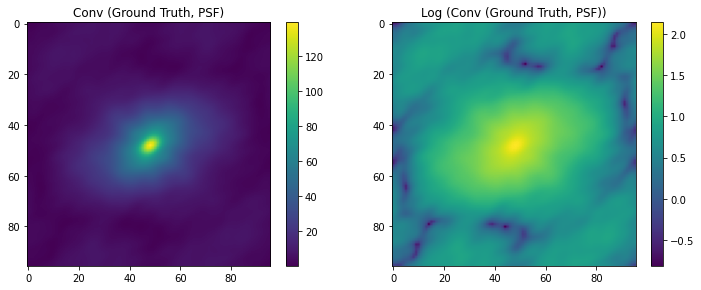

In [10]:
conv1 = np.multiply(gal_1_fft_GSO.array, psf_img1_fft)

final_gal = np.abs(np.fft.ifftshift(np.fft.ifft2(conv1)))                 # IFFT to get back to brightness domain
final_gal *= (np.sum(gal_1)/np.sum(final_gal))                            # Normalisation

fig = plt.figure(figsize=(12,12))

plt.subplot(121)
plt.imshow(final_gal)
plt.colorbar(shrink=0.375)
plt.title('Conv (Ground Truth, PSF)')

plt.subplot(122)
plt.imshow(np.log10(final_gal))
plt.colorbar(shrink=0.375)
plt.title('Log (Conv (Ground Truth, PSF))')

plt.show()

# FISTA

In [11]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def l1_norm(signal):

    return np.sum(np.abs(signal))

def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))

def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))

def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold /
                     np.maximum(np.finfo(np.float64).eps,
                                np.abs(data))), 0.0) * data, decimals=15)

def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [12]:
# Project negative values
def proj(xi):
    
    return np.maximum(xi,0)


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)

# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))


# The gradient
def grad(y, alpha_rec, psf):

    return fft(Ht(H(ifft(alpha_rec), psf) - y, psf))


# The cost function
def cost_func(y, alpha_rec, psf, lambda_):

    return (0.5 * np.linalg.norm(y - H(ifft(alpha_rec), psf)) ** 2 + lambda_ * np.linalg.norm(alpha_rec))


def runFISTA(observation, first_guess, psf, grad, n_iter, disp_step, lambda_val, gamma=1.0, ST_lambda=1e-10):
    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = np.zeros(observation.shape)
    count = 0
    
    # FISTA Parameters
    t_k = 1
    alpha_rec = first_guess
    xk = alpha_rec
            
    for i in range(n_iter):
        
        # FISTA Update
        x_k1 = xk
        alpha_temp = alpha_rec - gamma * grad(observation, alpha_rec, psf)
        alpha_temp = soft_thresh(alpha_temp, ST_lambda)
        xk = proj(alpha_temp)
        t_k1 = (1 + np.sqrt(1 + 4*t_k**2))/2
        alpha_rec = xk + (t_k - 1)/t_k1*(xk - x_k1)
        t_k = t_k1          
        
        cost.append(cost_func(observation, alpha_rec, psf, lambda_val))
        
        # Convert back to signal domain
        x_rec = np.abs(ifft(alpha_rec))
        
        # Compute NMSE
        nmse_arr[i] = nmse(gal_1, x_rec)  
        
        # Check if optimal reconstruction is achieved
        if nmse_arr[i]==np.min(nmse_arr):
            x_opt = x_rec

        if (i+1)%disp_step==0 and i!=0:
            plot_utils.plot_iter_np(x_rec, gal_1, observation, i)
    
    return x_rec, x_opt, nmse_arr, cost

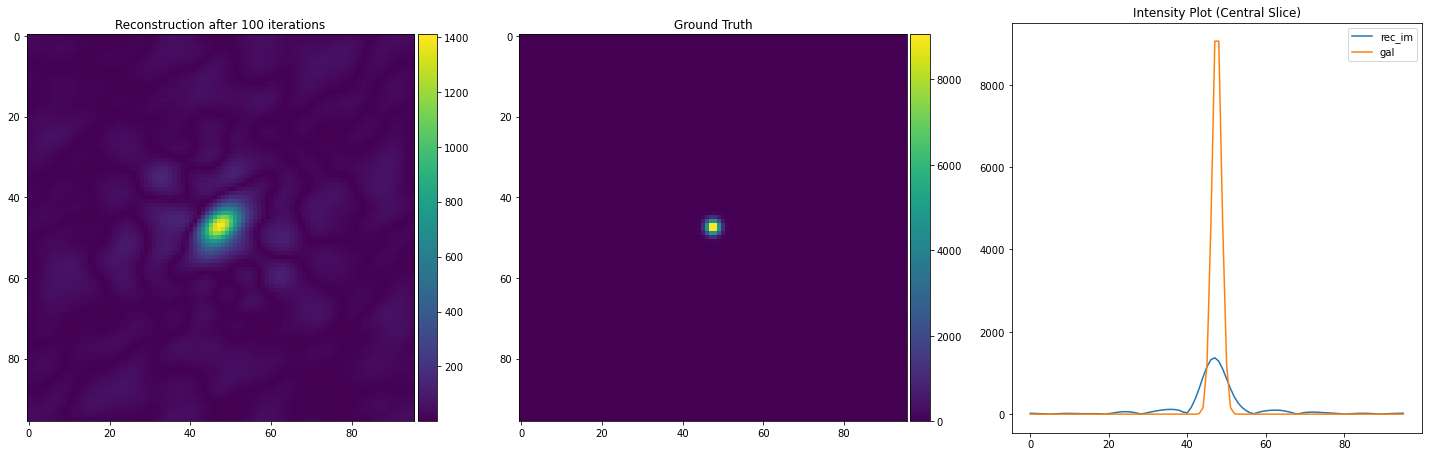

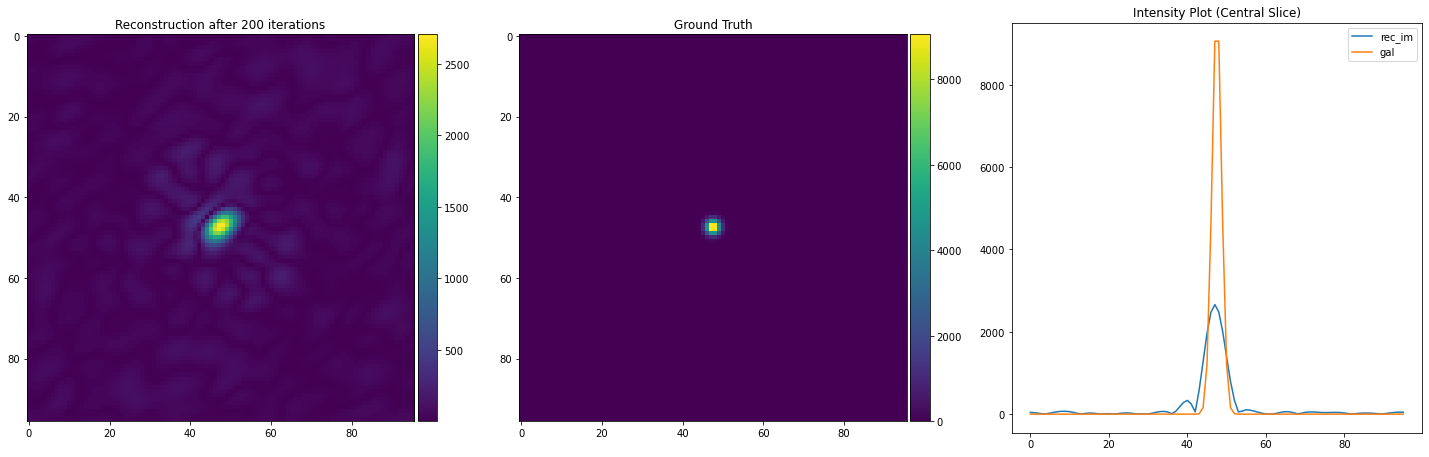

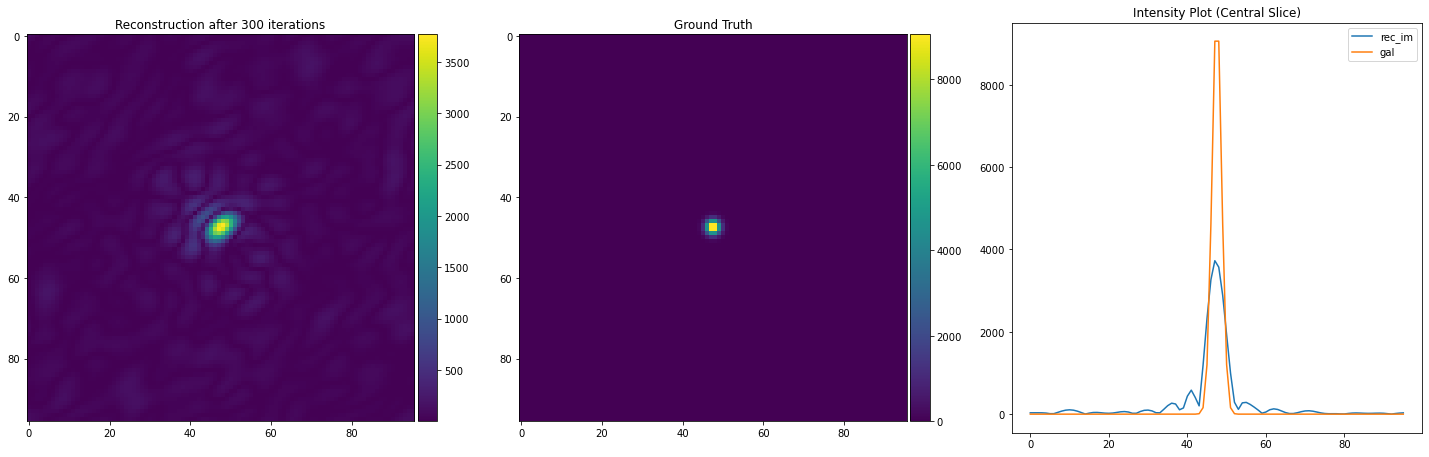

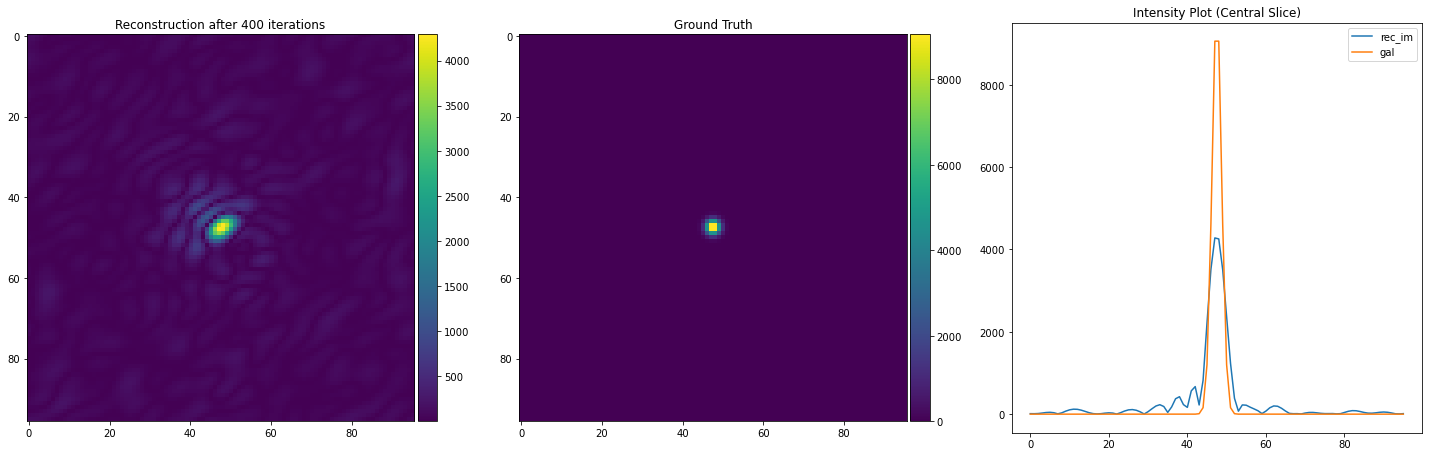

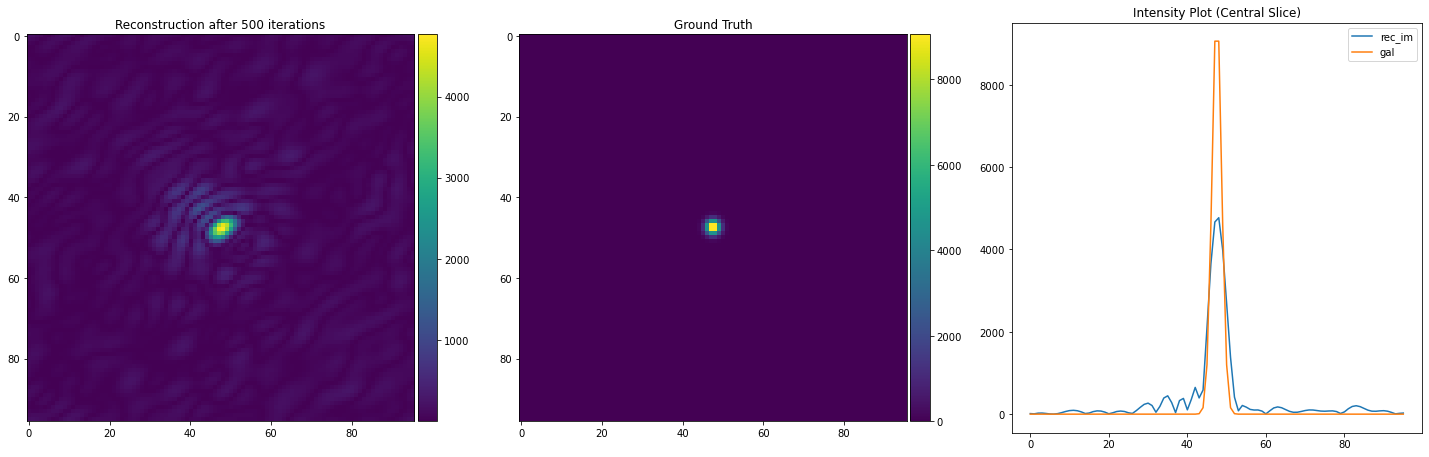

In [13]:
# Number of Iterations
n_iter = 500
disp_step = 100

# Deconvolve the image
x_rec, x_opt, nmse_arr, cost = runFISTA(final_gal, np.zeros(final_gal.shape), psf_img1, grad, 
                                        n_iter, disp_step, lambda_val=1e-4)

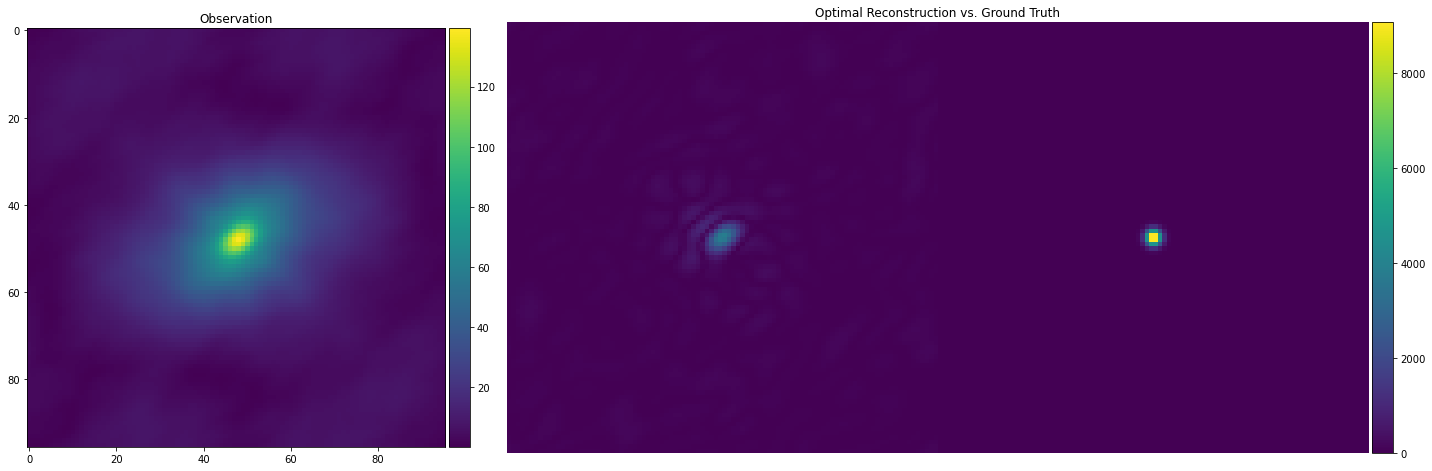

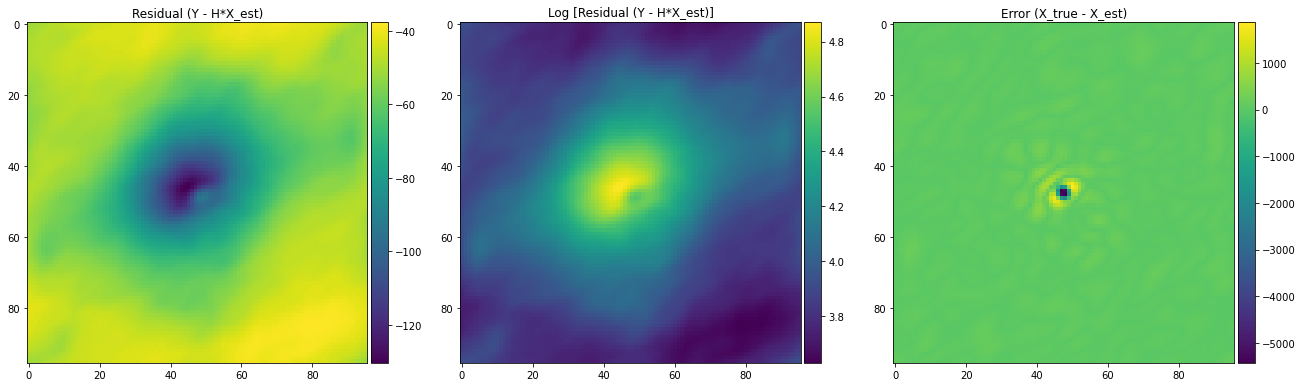

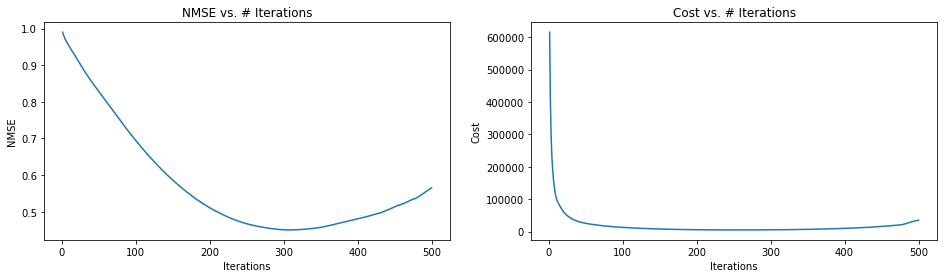


Minimum NMSE = 0.45045351792804345 (at [307] iterations)
Minimum Cost = 5334.4773496817 (at [255] iterations)


In [14]:
plot_utils.comparison_np(x_opt, gal_1, final_gal, psf_img1, fftconvolve, fft)
plot_utils.nmse_cost(nmse_arr, cost, n_iter)